
**Face and Facial Keypoint detection**

After We have trained a neural network to detect facial keypoints, we can then apply this network to any image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the data_transform we created and applied in Notebook 1, whose job was tp rescale, normalize and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2

import torch
from torch import nn
import torch.nn.functional as F

from model import Net
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

**1. Load the Image**

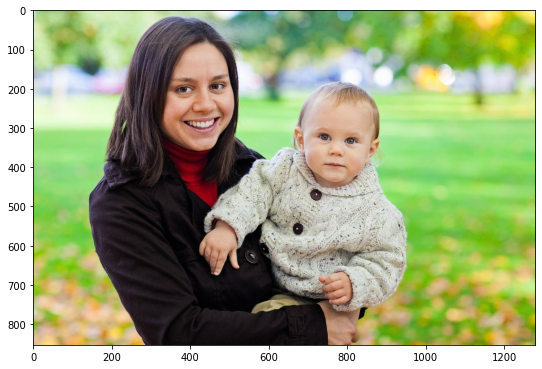

In [0]:
# Load the image
image = cv2.imread('images/baby.jpg')

# make a copy of the image
gray = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

**2. Detect all Faces**

Next, we will use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the cascasdes/ directory, to find any faces in your selected image.

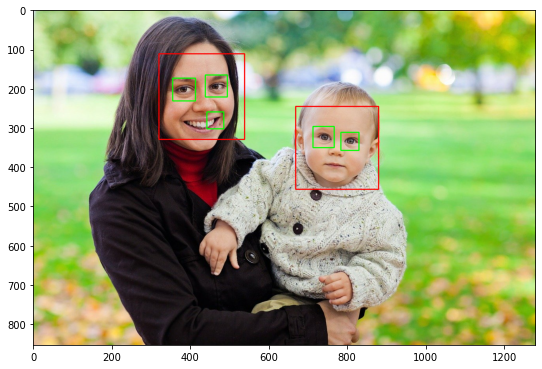

In [0]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

# load in a haar cascade classifier for detecting eyes
eye_cascade = cv2.CascadeClassifier('cascades/haarcascade_eye.xml')

# run the detector
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# make a copy of the original image to plot detections on it
image_copy = image.copy()

# loop over the detected faces and mark them on the image
for (x,y,w,h) in faces:
  # draw a rectangle around each face
  cv2.rectangle(image_copy, (x,y),(x+w,y+h),(255,0,0),2)

  # draw a rectangle around eyes
  rect_gray = gray[y:y+h, x:x+w]
  rect_color = image_copy[y:y+h, x:x+w]
  eyes = eye_cascade.detectMultiScale(rect_gray)

  for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(rect_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_copy)

**3. Loading the Pretrained Model**

In [0]:
model = Net()

# load checkpoints
checkpoints = torch.load('model.pth')

model.load_state_dict(checkpoints['state_dict'])
model.to(device)

# set model to evaluation mode
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

**4. Obtaining keypoints**

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

Transform each detected face into an input Tensor
You'll need to perform the following steps for each detected face:

1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

In [0]:

def show_all_keypoints(images, keypoints):  
    batch_size = len(images)
    for i, face in enumerate(images):
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the predicted key_pts data
        predicted_keypoints = keypoints[i].data
        predicted_keypoints = predicted_keypoints.cpu().numpy()
        # undo normalization of keypoints  
        predicted_keypoints = predicted_keypoints*50.0+100

        plt.imshow(face, cmap='gray')
        plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='red')
        
        plt.axis('off')

    plt.show()

(318, 318, 3)
(311, 311, 3)


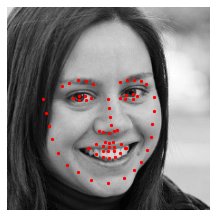

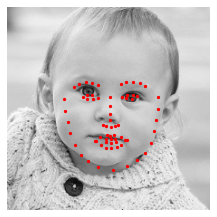

In [0]:
image_copy = np.copy(image)
#Including a padding to extract face as  HAAR classifier's bounding box, crops sections of the face

PADDING = 50
images, keypoints = [], []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]
    
    ## Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = (roi/255).astype(np.float32)
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    images.append(roi)
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if len(roi.shape) == 2:
        roi = np.expand_dims(roi, axis=0)
    else:
        roi = np.rollaxis(roi, 2, 0)
        
    # Match the convolution dimensions
    roi = np.expand_dims(roi, axis=0)
    
    ## Make facial keypoint predictions using your loaded, trained network 
    # Forward pass
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    roi = roi.to(device)
    output_pts = model.forward(roi)
    
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    keypoints.append(output_pts[0])
    
## Display each detected face and the corresponding keypoints
show_all_keypoints(images, keypoints)